In [758]:
import new_feature_extraction as nfe
from new_feature_extraction import read_data
from new_feature_extraction import read_logistic_data
from new_feature_extraction import read_buy_rating_data
from new_feature_extraction import get_all_stocks_df
from new_feature_extraction import get_stock_df
from new_feature_extraction import featurize
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

In [759]:
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = 'last_expr'

In [760]:
# df = get_stock_df("/Users/rithikpothuganti/cs467/csci467-project/data/uis.csv")
df = get_all_stocks_df()

In [761]:
from sklearn.model_selection import train_test_split

features = ['r_90d', 'r_180d', 'r_1y', 'r_2y', 'r_5y', 'r_10y']
# features = ['r_15d', 'r_30d', 'r_90d', 'r_180d', 'r_1y', 'r_2y', 'r_5y', 'r_10y']
# features = ['r_15d', 'r_30d', 'r_90d', 'r_180d', 'r_1y']
label = ['target_return', 'label', 'Date', 'Close/Last', 'rating']

X = df[features]
X.fillna(0, inplace=True)
y = df[label]

# Define the split indices
train_split_idx = int(len(X) * 0.5)
dev_split_idx = int(len(X) * 0.75)

# Train split
X_train_df, y_train_df = X.iloc[:train_split_idx], y.iloc[:train_split_idx]
train_dates = df["Date"].iloc[:train_split_idx]

# Dev (validation) split
X_dev_df, y_dev_df = X.iloc[train_split_idx:dev_split_idx], y.iloc[train_split_idx:dev_split_idx]
dev_dates = df["Date"].iloc[train_split_idx:dev_split_idx]

# Test split
X_test_df, y_test_df = X.iloc[dev_split_idx:], y.iloc[dev_split_idx:]
test_dates = df["Date"].iloc[dev_split_idx:]

# Combine dev and test sets
X_combined = pd.concat([X_dev_df, X_test_df], axis=0)
y_combined = pd.concat([y_dev_df, y_test_df], axis=0)
combined_dates = pd.concat([dev_dates, test_dates], axis=0)

# Shuffle combined dev and test sets
# X_dev, X_test, y_dev, y_test, dev_dates, test_dates = train_test_split(
#     X_combined, y_combined, combined_dates, test_size=len(y_test_df) / len(y_combined), shuffle=True
# )

dev_dates.head(10)


/var/folders/ps/hbp83zj53cb60mmc6jt7f2s00000gn/T/ipykernel_1944/3718641654.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna(0, inplace=True)


15070   2018-04-06
17046   2018-04-06
19086   2018-04-06
1022    2018-04-09
2992    2018-04-09
5032    2018-04-09
7008    2018-04-09
9048    2018-04-09
11055   2018-04-09
13031   2018-04-09
Name: Date, dtype: datetime64[ns]

In [762]:
# linear regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
DEGREE = 3
X_train, y_train = read_data(X_train_df, y_train_df)
X_train = featurize(X_train, d=DEGREE)
X_dev, y_dev = read_data(X_dev_df, y_dev_df)
X_dev = featurize(X_dev, d=DEGREE)
X_test, y_test = read_data(X_test_df, y_test_df)
X_test = featurize(X_test, d=DEGREE)


linreg_model = LinearRegression()
reg = linreg_model.fit(X_train, y_train)  # Train the model
y_pred = linreg_model.predict(X_train)
mse = mean_squared_error(y_train, y_pred)
rmse = math.sqrt(mse)
print("Train RMSE:", rmse)

y_pred = linreg_model.predict(X_dev)
mse = mean_squared_error(y_dev, y_pred)
rmse = math.sqrt(mse)
print("Dev RMSE:", rmse)


Train RMSE: 0.6354959360151319
Dev RMSE: 1.2799679477479202


In [763]:
y_pred = linreg_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = math.sqrt(mse)
print("Test RMSE:", rmse)

Test RMSE: 4.546552313520464


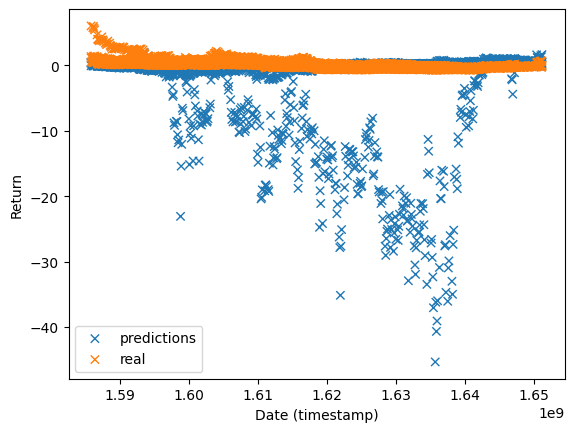

In [764]:
# plot linreg predictions
date_ints = test_dates.astype('int64') // 10**9
plt.scatter(date_ints, y_pred, marker='x', linestyle='')
plt.scatter(date_ints, y_test, marker='x', linestyle='')
plt.legend(["predictions" , "real"])
plt.xlabel("Date (timestamp)")
plt.ylabel("Return")
plt.show()


In [765]:
# softmax regression

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

DEGREE = 4
X_train, y_train = read_buy_rating_data(X_train_df, y_train_df)
X_train = featurize(X_train, d=DEGREE)
X_dev, y_dev = read_buy_rating_data(X_dev_df, y_dev_df)
X_dev = featurize(X_dev, d=DEGREE)

# Scale the features using StandardScaler
scaler = StandardScaler()
X_train_scaled = X_train
X_dev_scaled = X_dev

softmax_reg = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=200)
softmax_reg.fit(X_train_scaled, y_train)  # Train the model
w = softmax_reg.coef_.flatten()  # Weight vector
print(w)

def evaluate(model, X, y, name):
    preds = model.predict(X)  # vector of size n
    acc = np.mean(preds == y)
    print(f'{name} accuracy: ', acc)

evaluate(softmax_reg, X_train_scaled, y_train, "softmax regression, train")
evaluate(softmax_reg, X_dev_scaled, y_dev, "softmax regression, dev")


[-0.01896478 -0.02510884 -0.08960364 -0.05997078 -0.01495779  0.
 -0.0114844  -0.01869713 -0.10835335 -0.0353785  -0.04882574  0.
 -0.00747444 -0.02985423 -0.13331021  0.04073162 -0.14037527  0.
 -0.00533635 -0.06502601  0.04685781 -0.00367186  0.02693052  0.
 -0.02010484 -0.0366125  -0.08395232 -0.11680313 -0.0081263   0.
 -0.00915354 -0.02178903 -0.08351121 -0.10273903 -0.02089491  0.
 -0.00278458 -0.02558485 -0.06921906 -0.03312674 -0.03988721  0.
 -0.00237932 -0.0615651   0.03649524  0.00662459  0.00998298  0.
 -0.01477069 -0.03240011 -0.066013   -0.12778899  0.00476893  0.
 -0.00985096 -0.01815939 -0.03666295 -0.08577936  0.01244696  0.
 -0.00307508 -0.01657281  0.01258792  0.02919585  0.03429973  0.
 -0.00258131 -0.03694218  0.00853996 -0.00200245 -0.00480003  0.
 -0.00186707 -0.00381426 -0.00198772 -0.0640111   0.0086677   0.
 -0.00633434 -0.01451786  0.00446234 -0.02413603  0.02891481  0.
 -0.00274366 -0.01899372  0.02252294  0.0607103   0.08150508  0.
 -0.00267277 -0.03858863 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [766]:
X_test, y_test = read_buy_rating_data(X_test_df, y_test_df)
X_test = featurize(X_test, d=DEGREE)

evaluate(softmax_reg, X_test, y_test, "softmax regression, test")
preds = softmax_reg.predict(X_test)
np.mean(preds == 0)

softmax regression, test accuracy:  0.34462151394422313


0.2790836653386454

In [847]:
# Neural Network

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F

class ReturnPredictor(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(ReturnPredictor, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.bn2 = nn.BatchNorm1d(hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.bn3 = nn.BatchNorm1d(hidden_size)
        self.fc4 = nn.Linear(hidden_size, hidden_size)
        self.bn4 = nn.BatchNorm1d(hidden_size)
        self.fc5 = nn.Linear(hidden_size, hidden_size)
        self.bn5 = nn.BatchNorm1d(hidden_size)
        self.fc6 = nn.Linear(hidden_size, hidden_size)
        self.bn6 = nn.BatchNorm1d(hidden_size)
        self.fc7 = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = torch.tanh(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = torch.tanh(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = torch.tanh(self.bn3(self.fc3(x)))
        x = self.dropout(x)
        x = torch.tanh(self.bn4(self.fc4(x)))
        x = self.dropout(x)
        x = self.fc7(x)
        x = F.softmax(x, dim=1)
        return x


In [821]:
DEGREE = 1
X_train, y_train = read_buy_rating_data(X_train_df, y_train_df)
X_train = featurize(X_train, d=DEGREE)
X_dev, y_dev = read_buy_rating_data(X_dev_df, y_dev_df)
X_dev = featurize(X_dev, d=DEGREE)
# X_train = scaler.fit_transform(X_train)
# X_dev = scaler.transform(X_dev)

# # Convert data to PyTorch tensors
# X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
# y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
# X_dev_tensor = torch.tensor(X_dev, dtype=torch.float32)
# y_dev_tensor = torch.tensor(y_dev, dtype=torch.float32).view(-1, 1)
# # stats_2023_tensor = torch.tensor(stats_2023_values, dtype=torch.float32).to('cpu')

# # Create DataLoader objects
# train_data = TensorDataset(X_train_tensor, y_train_tensor)
# train_loader = DataLoader(train_data, batch_size=256, shuffle=False)

# test_data = TensorDataset(X_dev_tensor, y_dev_tensor)
# dev_loader = DataLoader(test_data, batch_size=256, shuffle=False)



In [851]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import random
import numpy as np

random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)

# Hyperparameters
input_size = X_train.shape[1]
hidden_size = 128
output_size = 5  # Number of classes
num_epochs = 40
batch_size = 256
learning_rate = 0.001

# Convert data to tensors and create DataLoader
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

dev_dataset = TensorDataset(torch.tensor(X_dev, dtype=torch.float32), torch.tensor(y_dev, dtype=torch.long))
dev_loader = DataLoader(dev_dataset, batch_size=batch_size, shuffle=False)

# Create the model, loss function, and optimizer
model = ReturnPredictor(input_size, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
accuracy = 0
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, (inputs, targets) in enumerate(train_loader):
        # Forward pass
        outputs = model(inputs)
        # print(outputs)
        loss = criterion(outputs, targets)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    # print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

    # Evaluate on validation set
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for inputs, targets in dev_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            # print(np.mean(predicted.numpy() == 4))
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

        accuracy = 100 * correct / total
print(f"Validation Accuracy: {accuracy:.2f}%")


Validation Accuracy: 56.43%


In [852]:
# Neural network test accuracy
X_test, y_test = read_buy_rating_data(X_test_df, y_test_df)
X_test = featurize(X_test, d=DEGREE)

test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.long))
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for inputs, targets in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()
    
    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")

Test Accuracy: 52.05%


In [771]:
# Random Forest

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler


DEGREE = 1
X_train, y_train = read_buy_rating_data(X_train_df, y_train_df)
X_train = featurize(X_train, d=DEGREE)
X_dev, y_dev = read_buy_rating_data(X_dev_df, y_dev_df)
X_dev = featurize(X_dev, d=DEGREE)

# Create the Random Forest model
rf_classifier = RandomForestClassifier(n_estimators=10, max_depth=100, min_samples_split=100, min_samples_leaf=10, max_features='auto', bootstrap=True)

# Train the model
rf_classifier.fit(X_train, y_train)

# Make predictions on the validation set
y_pred = rf_classifier.predict(X_dev)

# Calculate the accuracy
accuracy = accuracy_score(y_dev, y_pred) * 100
print(f"Validation Accuracy: {accuracy:.2f}%")


Validation Accuracy: 55.49%


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


In [853]:
# Random Forest Test Accuracy
X_test, y_test = read_buy_rating_data(X_test_df, y_test_df)
X_test = featurize(X_test, d=DEGREE)

y_pred = rf_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred) * 100
print(f"Test Accuracy: {accuracy:.2f}%")
print(np.sum(y_pred == 0))
print(len(y_pred))

print(np.mean(y_train == 0))
print(np.mean(y_train == 1))
print(np.mean(y_train == 2))
print(np.mean(y_train == 3))
print(np.mean(y_train == 4))

Test Accuracy: 36.06%
1009
5020
0.13467476840322742
0.06813427632234287
0.08357406116147027
0.11455324235481622
0.5990636517581432


In [773]:
# K nearest neighbors
from sklearn.neighbors import KNeighborsClassifier

DEGREE = 1
X_train, y_train = read_buy_rating_data(X_train_df, y_train_df)
X_train = featurize(X_train, d=DEGREE)
X_dev, y_dev = read_buy_rating_data(X_dev_df, y_dev_df)
X_dev = featurize(X_dev, d=DEGREE)

knn = KNeighborsClassifier(n_neighbors=500)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_dev)

accuracy_knn = accuracy_score(y_dev, y_pred)
print(f"Validation Accuracy: {accuracy_knn:.4f}")

Validation Accuracy: 0.6974


In [774]:
X_test, y_test = read_buy_rating_data(X_test_df, y_test_df)
X_test = featurize(X_test, d=DEGREE)

y_pred = knn.predict(X_test)
accuracy_knn = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy_knn:.4f}")

Test Accuracy: 0.4112
